In [6]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.image as mpimg
import os
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
import json
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import matplotlib.dates as mdates
import mplfinance as mpf
from dataset import get_dataloader, plot_statistical_analysis
from torch.utils.data import Subset
import random
from models import load_model_squeezenet
from performance import plot_full_evaluation_dashboard
from inference import inference, inference_df
from create_training_data import plot_rgb

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


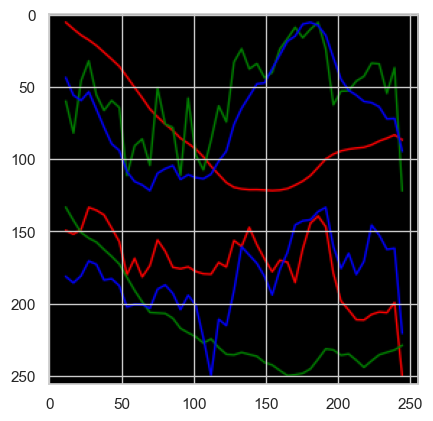

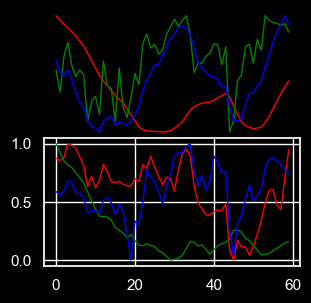

In [64]:
pred = 15
min_size = 50
max_size = 300
file_path = "Base_Test_2500pts v-Louis.xlsx"
graph_size = 156

data = pd.ExcelFile(file_path)

sheet_names = data.sheet_names
sheet_name = sheet_names[0]

sheet = data.parse(sheet_name)

test_file = pd.read_csv('test\\HON_0.csv')

img = mpimg.imread('test\\HON_0.png')
plt.imshow(img)
plt.show()

plot_rgb(test_file, test_file.columns[1:])
plt.axis('on')
plt.show()

In [65]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def get_csv_lengths(folder_path):
    lengths = []
    for filename in tqdm(os.listdir(folder_path)):
        if filename.endswith('.csv'):
            filepath = os.path.join(folder_path, filename)
            try:
                df = pd.read_csv(filepath)
                lengths.append(len(df))
            except Exception as e:
                print(f"Failed to read {filepath}: {e}")
    return lengths

# Paths to your folders
folder1 = 'data'
folder2 = 'test'

# Get lengths
lengths1 = get_csv_lengths(folder1)
lengths2 = get_csv_lengths(folder2)

# Plotting
plt.figure(figsize=(6, 6), dpi=100)  # 600x600 pixels
plt.hist(lengths1, bins=20, alpha=0.5, label='Folder 1', color='blue')
plt.hist(lengths2, bins=20, alpha=0.5, label='Folder 2', color='orange')
plt.xlabel('Number of Rows')
plt.ylabel('Number of CSV Files')
plt.title('CSV File Length Distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


  4%|▍         | 1370/34256 [00:11<04:25, 123.66it/s]


KeyboardInterrupt: 

In [ ]:
max(lengths1)

299

In [ ]:
with open('test_labels.json', "r") as f:
    test_labels_dict = json.load(f)

print(test_labels_dict['HON_0.png'])
print(test_file.iloc[[-1, -16]])

FileNotFoundError: [Errno 2] No such file or directory: 'test_labels.json'

In [ ]:
test_file.columns

Index(['Date', 'MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)',
       'RSI (14)', 'ADX (14)', 'CCI (20)'],
      dtype='object')

(256, 256, 4)


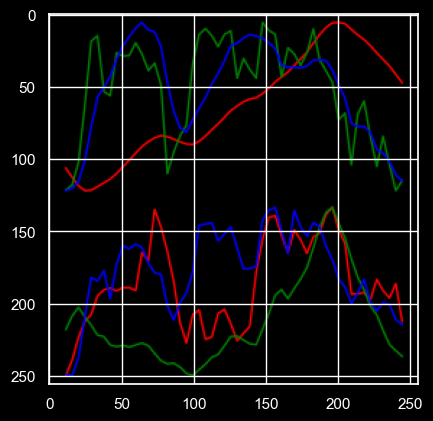

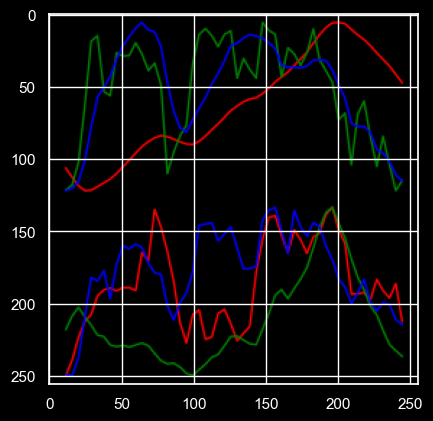

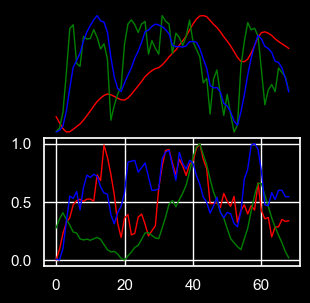

In [ ]:
pred = 15
min_size = 50
max_size = 300
file_path = "Base_Test_2500pts v-Louis.xlsx"
graph_size = 156

data = pd.ExcelFile(file_path)

sheet_names = data.sheet_names
sheet_name = sheet_names[0]

sheet = data.parse(sheet_name)

test_file = pd.read_csv('data\\AAPL_2.csv')

img = mpimg.imread('data\\AAPL_2.png')

rgb_img = img[:, :, :3]

print(img.shape)
plt.imshow(img)
plt.show()
plt.imshow(rgb_img)
plt.show()


plot_rgb(test_file, ['MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)', 'RSI (14)', 'ADX (14)', 'CCI (20)'])
plt.axis('on')
plt.show()

In [ ]:
test_file.columns

Index(['Date', 'MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)',
       'RSI (14)', 'ADX (14)', 'CCI (20)'],
      dtype='object')

In [ ]:
value_wished = ['Date', 'MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)', 'RSI (14)', 'ADX (14)', 'CCI (20)']

a = ['MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)', 'RSI (14)', 'ADX (14)', 'CCI (20)']

[x for x in value_wished if x in a]

['MACD (12,26,9)',
 'STOCH-R (14)',
 'STOCH-RL (15,15,1)',
 'RSI (14)',
 'ADX (14)',
 'CCI (20)']

In [ ]:
set(value_wished)

{'ADX (14)',
 'CCI (20)',
 'Date',
 'MACD (12,26,9)',
 'RSI (14)',
 'STOCH-R (14)',
 'STOCH-RL (15,15,1)'}

In [ ]:
import os

os.path.join('azera.aze'.split('.')[:-1], '.csv')

TypeError: expected str, bytes or os.PathLike object, not list

In [25]:
TRAIN_DIR = "data/"
TEST_DIR = "test/"
TEST_SYNTH_DIR = 'test_synth/'

LABELS_DIR = "labels"
TRAIN_LABEL_FILE = "train_labels.json"
TEST_LABEL_FILE = "test_labels.json"
TEST_SYNTH_LABEL_FILE = "test_synth_labels.json"
TRAIN_LABEL_PATH = os.path.join(LABELS_DIR, TRAIN_LABEL_FILE)
TEST_LABEL_PATH = os.path.join(LABELS_DIR, TEST_LABEL_FILE)
TEST_SYNTH_LABEL_PATH = os.path.join(LABELS_DIR, TEST_SYNTH_LABEL_FILE)

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 1


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_DIR = 'model'
MODEL_NAME = 'VIT_256'
MODEL_FILE = MODEL_NAME + '.pth'
MODEL_PATH = os.path.join(MODEL_DIR, MODEL_FILE)

PERF_DIR = 'performances'
PERF_FILE = MODEL_NAME + '.png'
PERF_PATH = os.path.join(PERF_DIR, PERF_FILE)

INDICS = ['MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)', 'RSI (14)', 'ADX (14)', 'CCI (20)']


LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 100
IMAGE_SIZE = 128
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_LAYERS = 8
MLP_HEAD_UNITS = [2048, 1024]

In [26]:
import importlib
import dataset
importlib.reload(dataset)
from dataset import get_dataloader, compute_mean_std

In [27]:
mean, std = compute_mean_std (TRAIN_DIR, IMAGE_SIZE)

train_loader, train_dataset = get_dataloader(TRAIN_DIR, TRAIN_LABEL_PATH, TRAIN_BATCH_SIZE, img_size= IMAGE_SIZE, mean= mean, std = std)

test_loader, test_dataset = get_dataloader(TEST_DIR, TEST_LABEL_PATH, TEST_BATCH_SIZE, shuffle = False, img_size= IMAGE_SIZE, mean= mean, std = std)

test_synth_loader, test_synth_dataset = get_dataloader(TEST_SYNTH_DIR, TEST_SYNTH_LABEL_PATH, TEST_BATCH_SIZE, shuffle = False, img_size= IMAGE_SIZE, mean= mean, std = std)

# Create a smaller test subset
subset_size = 1000
assert subset_size <= len(test_dataset), "Subset size exceeds size of test dataset"

# Random sample without replacement
random.seed(42)
indices = random.sample(range(len(test_dataset)), subset_size)

# Wrap in Subset and new DataLoader
small_test_dataset = Subset(test_dataset, indices)
small_test_loader = DataLoader(small_test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)


indices = random.sample(range(len(test_synth_dataset)), subset_size)

# Wrap in Subset and new DataLoader
small_synth_test_dataset = Subset(test_synth_dataset, indices)
small_synth_test_loader = DataLoader(small_synth_test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

In [28]:
class CreatePatchesLayer(torch.nn.Module):
  """Custom PyTorch Layer to Extract Patches from Images."""

  def __init__(
    self,
    patch_size: int,
    strides: int,
  ) -> None:
    """Init Variables."""
    super().__init__()
    self.unfold_layer = torch.nn.Unfold(
      kernel_size=patch_size, stride=strides
    )

  def forward(self, images: torch.Tensor) -> torch.Tensor:
    """Forward Pass to Create Patches."""
    patched_images = self.unfold_layer(images)
    return patched_images.permute((0, 2, 1))

441


441it [00:02, 169.98it/s]


<Figure size 400x400 with 0 Axes>

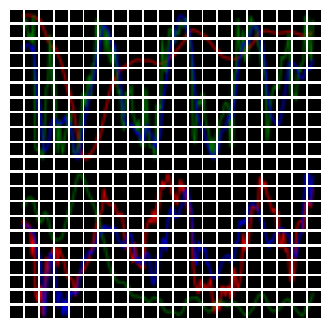

In [29]:
batch_of_images = next(iter(train_loader))[0][0].unsqueeze(dim=0)

plt.figure(figsize=(4, 4))
image = torch.permute(batch_of_images[0], (1, 2, 0)).numpy()
image = (image * std) + mean
image[image < 0] = 0
plt.imshow(image)
plt.axis("off")
plt.savefig("img.png", bbox_inches="tight", pad_inches=0)
plt.clf()

patch_layer = CreatePatchesLayer(patch_size=PATCH_SIZE, strides=PATCH_SIZE)
patched_image = patch_layer(batch_of_images)
patched_image = patched_image.squeeze()
print(len(patched_image))
plt.figure(figsize=(4, 4))
nb = int(np.sqrt(NUM_PATCHES))
for idx, patch in tqdm(enumerate(patched_image)):
  ax = plt.subplot(nb, nb, idx + 1)
  patch_img = torch.reshape(patch, (3, PATCH_SIZE, PATCH_SIZE))
  patch_img = torch.permute(patch_img, (1, 2, 0)).numpy()
  patch_img = (patch_img * std) + mean
  patch_img[patch_img < 0] = 0
  plt.imshow(patch_img)
  plt.axis("off")
plt.savefig("patched_img.png", bbox_inches="tight", pad_inches=0)

In [30]:
class PatchEmbeddingLayer(torch.nn.Module):
  """Positional Embedding Layer for Images of Patches."""

  def __init__(
    self,
    num_patches: int,
    #batch_size: int,
    patch_size: int,
    embed_dim: int,
    device: torch.device,
  ) -> None:
    """Init Function."""
    super().__init__()
    self.num_patches = num_patches
    self.patch_size = patch_size
    self.position_emb = torch.nn.Embedding(
      num_embeddings=num_patches + 1, embedding_dim=embed_dim
    )
    self.projection_layer = torch.nn.Linear(
      patch_size * patch_size * 3, embed_dim
    )
    #self.class_parameter = torch.nn.Parameter(      torch.rand(batch_size, 1, embed_dim).to(device),      requires_grad=True,    )
    self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))

    self.device = device

  def forward(self, patches: torch.Tensor) -> torch.Tensor:
    """Forward Pass."""

    batch_size = patches.size(0)
    positions = (
      torch.arange(start=0, end=self.num_patches + 1, step=1)
      .to(self.device)
      .unsqueeze(dim=0)
    )
    patches = self.projection_layer(patches)
    position_embeddings = self.position_emb(positions)
    encoded_patches = torch.cat(
      (self.class_token.expand(batch_size, -1, -1), patches), dim=1
    ) + position_embeddings.expand(batch_size, -1, -1)
    return encoded_patches

In [31]:
from typing import Type

import torch

In [32]:
def create_mlp_block(
    input_features: int,
    output_features: list[int],
    activation_function: Type[torch.nn.Module],
    dropout_rate: float,
) -> torch.nn.Module:
    """Create a Feed Forward Network for the Transformer Layer."""
    layer_list = []
    for idx in range(  # pylint: disable=consider-using-enumerate
        len(output_features)
    ):
        if idx == 0:
            linear_layer = torch.nn.Linear(
                in_features=input_features, out_features=output_features[idx]
            )
        else:
            linear_layer = torch.nn.Linear(
                in_features=output_features[idx - 1],
                out_features=output_features[idx],
            )
        dropout = torch.nn.Dropout(p=dropout_rate)
        layers = torch.nn.Sequential(
            linear_layer, activation_function(), dropout
        )
        layer_list.append(layers)
    return torch.nn.Sequential(*layer_list)

In [33]:
class TransformerBlock(torch.nn.Module):
  """Transformer Block Layer."""

  def __init__(
    self,
    num_heads: int,
    key_dim: int,
    embed_dim: int,
    ff_dim: int,
    dropout_rate: float = 0.1,
  ) -> None:
    """Init variables and layers."""
    super().__init__()
    self.layer_norm_input = torch.nn.LayerNorm(
      normalized_shape=embed_dim, eps=1e-6
    )
    self.attn = torch.nn.MultiheadAttention(
      embed_dim=embed_dim,
      num_heads=num_heads,
      kdim=key_dim,
      vdim=key_dim,
      batch_first=True,
    )

    self.dropout_1 = torch.nn.Dropout(p=dropout_rate)
    self.layer_norm_1 = torch.nn.LayerNorm(
      normalized_shape=embed_dim, eps=1e-6
    )
    self.layer_norm_2 = torch.nn.LayerNorm(
      normalized_shape=embed_dim, eps=1e-6
    )
    self.ffn = create_mlp_block(
      input_features=embed_dim,
      output_features=[ff_dim, embed_dim],
      activation_function=torch.nn.GELU,
      dropout_rate=dropout_rate,
    )

  def forward(self, inputs: torch.Tensor) -> torch.Tensor:
    """Forward Pass."""
    layer_norm_inputs = self.layer_norm_input(inputs)
    attention_output, _ = self.attn(
      query=layer_norm_inputs,
      key=layer_norm_inputs,
      value=layer_norm_inputs,
    )
    attention_output = self.dropout_1(attention_output)
    out1 = self.layer_norm_1(inputs + attention_output)
    ffn_output = self.ffn(out1)
    output = self.layer_norm_2(out1 + ffn_output)
    return output

In [34]:
class ViTMultiLabelClassifierModel(torch.nn.Module):
  """ViT Model for Multi-Label Image Classification."""

  def __init__(
      self,
      num_transformer_layers: int,
      embed_dim: int,
      feed_forward_dim: int,
      num_heads: int,
      patch_size: int,
      num_patches: int,
      mlp_head_units: list[int],
      num_classes: int,
      batch_size: int,
      device: torch.device,
  ) -> None:
      """Init Function."""
      super().__init__()
      self.create_patch_layer = CreatePatchesLayer(patch_size, patch_size)
      self.patch_embedding_layer = PatchEmbeddingLayer(
          num_patches,  patch_size, embed_dim, device
      )
      self.transformer_layers = torch.nn.ModuleList()
      for _ in range(num_transformer_layers):
          self.transformer_layers.append(
              TransformerBlock(
                  num_heads, embed_dim, embed_dim, feed_forward_dim
              )
          )

      self.mlp_block = create_mlp_block(
          input_features=embed_dim,
          output_features=mlp_head_units,
          activation_function=torch.nn.GELU,
          dropout_rate=0.5,
      )

      self.logits_layer = torch.nn.Linear(mlp_head_units[-1], num_classes)
      self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      """Forward Pass."""
      x = self.create_patch_layer(x)
      x = self.patch_embedding_layer(x)
      for transformer_layer in self.transformer_layers:
          x = transformer_layer(x)
      x = x[:, 0]  # CLS token
      x = self.mlp_block(x)
      logits = self.logits_layer(x)
      return self.sigmoid(logits)  # Raw logits for BCEWithLogitsLoss


In [35]:
import sys
from typing import Callable

In [36]:
def calculate_accuracy(
    outputs: torch.Tensor, ground_truth: torch.Tensor
) -> tuple[int, int]:
    """Simple Function to Calculate Acccuracy."""
    softmaxed_output = torch.nn.functional.softmax(outputs, dim=1)
    #predictions = torch.argmax(softmaxed_output, dim=1)
    num_correct = int(torch.sum(torch.eq(softmaxed_output, ground_truth)).item())
    return num_correct, ground_truth.size()[0]


def calculate_accuracy_top_5(
    outputs: torch.Tensor, ground_truth: torch.Tensor
) -> tuple[int, int]:
    """Simple Function to Calculate Top-5 Acccuracy."""
    num_correct = 0
    softmaxed_output = torch.nn.functional.softmax(outputs, dim=1)
    #predictions = torch.argsort(softmaxed_output, dim=1, descending=True)
    for idx, x in enumerate(ground_truth):
        if torch.isin(x, softmaxed_output[idx, :4]):
            num_correct += 1
    return num_correct, ground_truth.size(0)

In [37]:
def train_network(
  model: torch.nn.Module,
  num_epochs: int,
  optimizer: torch.optim.Optimizer,
  loss_function: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
  trainloader: torch.utils.data.DataLoader,
  validloader: torch.utils.data.DataLoader,
  device: torch.device,
) -> None:
  """Train the Network."""
  print("Training Started")
  for epoch in range(1, num_epochs + 1):
    sys.stdout.flush()
    train_loss = []
    valid_loss = []
    num_examples_train = 0
    num_correct_train = 0
    num_examples_valid = 0
    num_correct_valid = 0
    num_correct_train_5 = 0
    num_correct_valid_5 = 0
    model.train()
    for batch in trainloader:
      optimizer.zero_grad()
      x = batch[0].to(device)
      y = batch[1].to(device)
      outputs = model(x)
      loss = loss_function(outputs, y)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
      num_corr, num_ex = calculate_accuracy(outputs, y)
      num_corr_5, _ = calculate_accuracy_top_5(outputs, y)
      num_examples_train += num_ex
      num_correct_train += num_corr
      num_correct_train_5 += num_corr_5

    model.eval()
    with torch.no_grad():
      for batch in validloader:
        images = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)
        valid_loss.append(loss.item())
        num_corr, num_ex = calculate_accuracy(outputs, labels)
        num_corr_5, _ = calculate_accuracy_top_5(outputs, labels)
        num_examples_valid += num_ex
        num_correct_valid += num_corr
        num_correct_valid_5 += num_corr_5

    print(
      f"Epoch: {epoch}, Training Loss: {np.mean(train_loss):.4f}, Validation Loss: {np.mean(valid_loss):.4f}, Training Accuracy: {num_correct_train/num_examples_train:.4f}, Validation Accuracy: {num_correct_valid/num_examples_valid:.4f}, Training Accuracy Top-5: {num_correct_train_5/num_examples_train:.4f}, Validation Accuracy Top-5: {num_correct_valid_5/num_examples_valid:.4f}"
    )

In [38]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch
from typing import Callable
import sys

def train_network(
  model: torch.nn.Module,
  num_epochs: int,
  optimizer: torch.optim.Optimizer,
  loss_function: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
  trainloader: torch.utils.data.DataLoader,
  validloader: torch.utils.data.DataLoader,
  device: torch.device,
  threshold: float = 0.5
) -> None:
  """Train the Network (Multi-label)."""
  print("Training Started")

  for epoch in range(1, num_epochs + 1):
    sys.stdout.flush()
    train_loss = []
    valid_loss = []

    all_train_preds, all_train_labels = [], []
    all_valid_preds, all_valid_labels = [], []

    model.train()
    for x, y, *_ in tqdm(trainloader):
      x, y = x.to(device), y.float().to(device)
      optimizer.zero_grad()
      outputs = model(x)
      loss = loss_function(outputs, y)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

      probs = torch.sigmoid(outputs)
      preds = (probs > threshold).int()
      all_train_preds.append(preds.cpu().numpy())
      all_train_labels.append(y.cpu().numpy())

    model.eval()
    with torch.no_grad():
      for x, y, *_ in validloader:
        x, y = x.to(device), y.float().to(device)
        outputs = model(x)
        loss = loss_function(outputs, y)
        valid_loss.append(loss.item())

        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).int()
        all_valid_preds.append(preds.cpu().numpy())
        all_valid_labels.append(y.cpu().numpy())

    # Flatten predictions and labels
    y_train_true = np.vstack(all_train_labels)
    y_train_pred = np.vstack(all_train_preds)
    y_valid_true = np.vstack(all_valid_labels)
    y_valid_pred = np.vstack(all_valid_preds)

    # Metrics
    train_acc = accuracy_score(y_train_true, y_train_pred)
    valid_acc = accuracy_score(y_valid_true, y_valid_pred)
    train_f1 = f1_score(y_train_true, y_train_pred, average='macro')
    valid_f1 = f1_score(y_valid_true, y_valid_pred, average='macro')

    print(
      f"Epoch {epoch}: "
      f"Train Loss: {np.mean(train_loss):.4f}, Val Loss: {np.mean(valid_loss):.4f}, "
      f"Train Acc: {train_acc:.4f}, Val Acc: {valid_acc:.4f}, "
      f"Train F1: {train_f1:.4f}, Val F1: {valid_f1:.4f}"
    )


In [39]:
import pytorch_model_summary as pms
model = ViTMultiLabelClassifierModel(
    num_transformer_layers=TRANSFORMER_LAYERS,
    embed_dim=PROJECTION_DIM,
    feed_forward_dim=PROJECTION_DIM * 2,
    num_heads=NUM_HEADS,
    patch_size=PATCH_SIZE,
    num_patches=NUM_PATCHES,
    mlp_head_units=MLP_HEAD_UNITS,
    num_classes=6,
    batch_size=BATCH_SIZE,
    device=DEVICE,
).to(DEVICE)

pms.summary(
    model,
    torch.rand((BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)).to(device=DEVICE),
    show_input=False,
    print_summary=True,
    max_depth=5,
    show_parent_layers=True,
)

--------------------------------------------------------------------------------------------------------------------------
                                      Parent Layers       Layer (type)        Output Shape         Param #     Tr. Param #
    ViTMultiLabelClassifierModel/CreatePatchesLayer           Unfold-1      [32, 108, 441]               0               0
   ViTMultiLabelClassifierModel/PatchEmbeddingLayer           Linear-2       [32, 441, 64]           6,976           6,976
   ViTMultiLabelClassifierModel/PatchEmbeddingLayer        Embedding-3        [1, 442, 64]          28,288          28,288
      ViTMultiLabelClassifierModel/TransformerBlock        LayerNorm-4       [32, 442, 64]             128             128
      ViTMultiLabelClassifierModel/TransformerBlock          Dropout-5       [32, 442, 64]               0               0
      ViTMultiLabelClassifierModel/TransformerBlock        LayerNorm-6       [32, 442, 64]             128             128
      ViTMultiLa

'--------------------------------------------------------------------------------------------------------------------------\n                                      Parent Layers       Layer (type)        Output Shape         Param #     Tr. Param #\n==========================================================================================================================\n    ViTMultiLabelClassifierModel/CreatePatchesLayer           Unfold-1      [32, 108, 441]               0               0\n   ViTMultiLabelClassifierModel/PatchEmbeddingLayer           Linear-2       [32, 441, 64]           6,976           6,976\n   ViTMultiLabelClassifierModel/PatchEmbeddingLayer        Embedding-3        [1, 442, 64]          28,288          28,288\n      ViTMultiLabelClassifierModel/TransformerBlock        LayerNorm-4       [32, 442, 64]             128             128\n      ViTMultiLabelClassifierModel/TransformerBlock          Dropout-5       [32, 442, 64]               0               0\n      V

In [40]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch
from typing import Callable
import sys
from tqdm import tqdm

def train_network(
  model: torch.nn.Module,
  num_epochs: int,
  optimizer: torch.optim.Optimizer,
  loss_function: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
  trainloader: torch.utils.data.DataLoader,
  validloader: torch.utils.data.DataLoader,
  device: torch.device,
  threshold: float = 0.5,
  patience: int = 5,
  lr_decay_factor: float = 0.1,
  min_lr: float = 1e-6
) -> None:
  """Train the Network (Multi-label) with early stopping and LR decay."""
  print("Training Started")

  best_val_loss = float('inf')
  epochs_no_improve = 0

  # Learning rate scheduler
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=lr_decay_factor, patience=2, min_lr=min_lr
  )

  for epoch in range(1, num_epochs + 1):
    sys.stdout.flush()
    train_loss = []
    valid_loss = []

    all_train_preds, all_train_labels = [], []
    all_valid_preds, all_valid_labels = [], []

    model.train()
    for x, y, *_ in tqdm(trainloader, desc=f"Epoch {epoch} [Train]"):
      x, y = x.to(device), y.float().to(device)
      optimizer.zero_grad()
      outputs = model(x)
      loss = loss_function(outputs, y)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

      probs = torch.sigmoid(outputs)
      preds = (probs > threshold).int()
      all_train_preds.append(preds.cpu().numpy())
      all_train_labels.append(y.cpu().numpy())

    model.eval()
    with torch.no_grad():
      for x, y, *_ in tqdm(validloader, desc=f"Epoch {epoch} [Valid]"):
        x, y = x.to(device), y.float().to(device)
        outputs = model(x)
        loss = loss_function(outputs, y)
        valid_loss.append(loss.item())

        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).int()
        all_valid_preds.append(preds.cpu().numpy())
        all_valid_labels.append(y.cpu().numpy())

    # Flatten predictions and labels
    y_train_true = np.vstack(all_train_labels)
    y_train_pred = np.vstack(all_train_preds)
    y_valid_true = np.vstack(all_valid_labels)
    y_valid_pred = np.vstack(all_valid_preds)

    # Metrics
    train_acc = accuracy_score(y_train_true, y_train_pred)
    valid_acc = accuracy_score(y_valid_true, y_valid_pred)
    train_f1 = f1_score(y_train_true, y_train_pred, average='macro')
    valid_f1 = f1_score(y_valid_true, y_valid_pred, average='macro')

    val_loss_mean = np.mean(valid_loss)
    train_loss_mean = np.mean(train_loss)

    print(
      f"Epoch {epoch}: "
      f"Train Loss: {train_loss_mean:.4f}, Val Loss: {val_loss_mean:.4f}, "
      f"Train Acc: {train_acc:.4f}, Val Acc: {valid_acc:.4f}, "
      f"Train F1: {train_f1:.4f}, Val F1: {valid_f1:.4f}"
    )

    # Learning rate scheduling
    scheduler.step(val_loss_mean)

    # Early stopping check
    if val_loss_mean < best_val_loss:
      best_val_loss = val_loss_mean
      epochs_no_improve = 0
      best_model_state = model.state_dict()  # Save best model
    else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        model.load_state_dict(best_model_state)  # Restore best model
        break


In [ ]:
optimizer = torch.optim.AdamW(
    params=filter(lambda param: param.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)
loss_function = torch.nn.BCELoss()

train_network(
    model=model,
    num_epochs=NUM_EPOCHS,
    optimizer=optimizer,
    loss_function=loss_function,
    trainloader=train_loader,
    validloader=small_test_loader,
    device=DEVICE,
)

Training Started


Epoch 1 [Valid]: 100%|██████████| 1000/1000 [00:24<00:00, 40.97it/s]

Epoch 1: Train Loss: 0.6966, Val Loss: 0.6934, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 2 [Valid]: 100%|██████████| 1000/1000 [00:14<00:00, 69.91it/s]

Epoch 2: Train Loss: 0.6954, Val Loss: 0.6944, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 3 [Valid]: 100%|██████████| 1000/1000 [00:14<00:00, 70.49it/s]

Epoch 3: Train Loss: 0.6949, Val Loss: 0.6937, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 4 [Valid]: 100%|██████████| 1000/1000 [00:19<00:00, 51.94it/s]


Epoch 4: Train Loss: 0.6955, Val Loss: 0.6929, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635


Epoch 5 [Valid]: 100%|██████████| 1000/1000 [00:27<00:00, 36.60it/s]

Epoch 5: Train Loss: 0.6944, Val Loss: 0.6927, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 6 [Valid]: 100%|██████████| 1000/1000 [00:22<00:00, 44.69it/s]

Epoch 6: Train Loss: 0.6656, Val Loss: 0.6430, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 7 [Valid]: 100%|██████████| 1000/1000 [00:15<00:00, 66.21it/s]

Epoch 7: Train Loss: 0.6389, Val Loss: 0.6393, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 8 [Valid]: 100%|██████████| 1000/1000 [00:15<00:00, 64.86it/s]

Epoch 8: Train Loss: 0.6273, Val Loss: 0.6293, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 9 [Valid]: 100%|██████████| 1000/1000 [00:15<00:00, 63.94it/s]

Epoch 9: Train Loss: 0.6224, Val Loss: 0.6443, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 10 [Valid]: 100%|██████████| 1000/1000 [00:15<00:00, 66.51it/s]

Epoch 10: Train Loss: 0.6194, Val Loss: 0.6273, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 11 [Valid]: 100%|██████████| 1000/1000 [00:16<00:00, 62.07it/s]

Epoch 11: Train Loss: 0.6197, Val Loss: 0.6222, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 12 [Valid]: 100%|██████████| 1000/1000 [00:14<00:00, 69.80it/s]


Epoch 12: Train Loss: 0.6166, Val Loss: 0.6197, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635


Epoch 13 [Valid]: 100%|██████████| 1000/1000 [00:14<00:00, 71.10it/s]

Epoch 13: Train Loss: 0.6133, Val Loss: 0.6180, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 14 [Valid]: 100%|██████████| 1000/1000 [00:15<00:00, 66.57it/s]

Epoch 14: Train Loss: 0.6099, Val Loss: 0.6117, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 15 [Valid]: 100%|██████████| 1000/1000 [00:14<00:00, 68.98it/s]

Epoch 15: Train Loss: 0.6047, Val Loss: 0.6171, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 16 [Valid]: 100%|██████████| 1000/1000 [00:14<00:00, 66.85it/s]

Epoch 16: Train Loss: 0.6002, Val Loss: 0.6064, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 17 [Valid]: 100%|██████████| 1000/1000 [00:14<00:00, 70.02it/s]

Epoch 17: Train Loss: 0.5987, Val Loss: 0.6049, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 18 [Valid]: 100%|██████████| 1000/1000 [00:14<00:00, 69.74it/s]

Epoch 18: Train Loss: 0.5942, Val Loss: 0.6070, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 19 [Valid]: 100%|██████████| 1000/1000 [00:24<00:00, 40.55it/s]

Epoch 19: Train Loss: 0.5918, Val Loss: 0.6071, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 20 [Valid]: 100%|██████████| 1000/1000 [00:15<00:00, 66.13it/s]

Epoch 20: Train Loss: 0.5889, Val Loss: 0.6115, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 21 [Valid]: 100%|██████████| 1000/1000 [00:15<00:00, 64.54it/s]

Epoch 21: Train Loss: 0.5839, Val Loss: 0.5999, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 22 [Valid]: 100%|██████████| 1000/1000 [00:15<00:00, 66.47it/s]

Epoch 22: Train Loss: 0.5813, Val Loss: 0.5995, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 23 [Train]:  48%|████▊     | 77/161 [01:33<02:17,  1.63s/it]

100%|██████████| 1000/1000 [00:23<00:00, 42.57it/s]
c:\Users\louis\Desktop\stage\performance.py:225: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp_df.groupby("len_bin")
c:\Users\louis\Desktop\stage\performance.py:225: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp_df.groupby("len_bin")
c:\Users\louis\Desktop\stage\performance.py:225: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tem

Saved to model\VIT.png


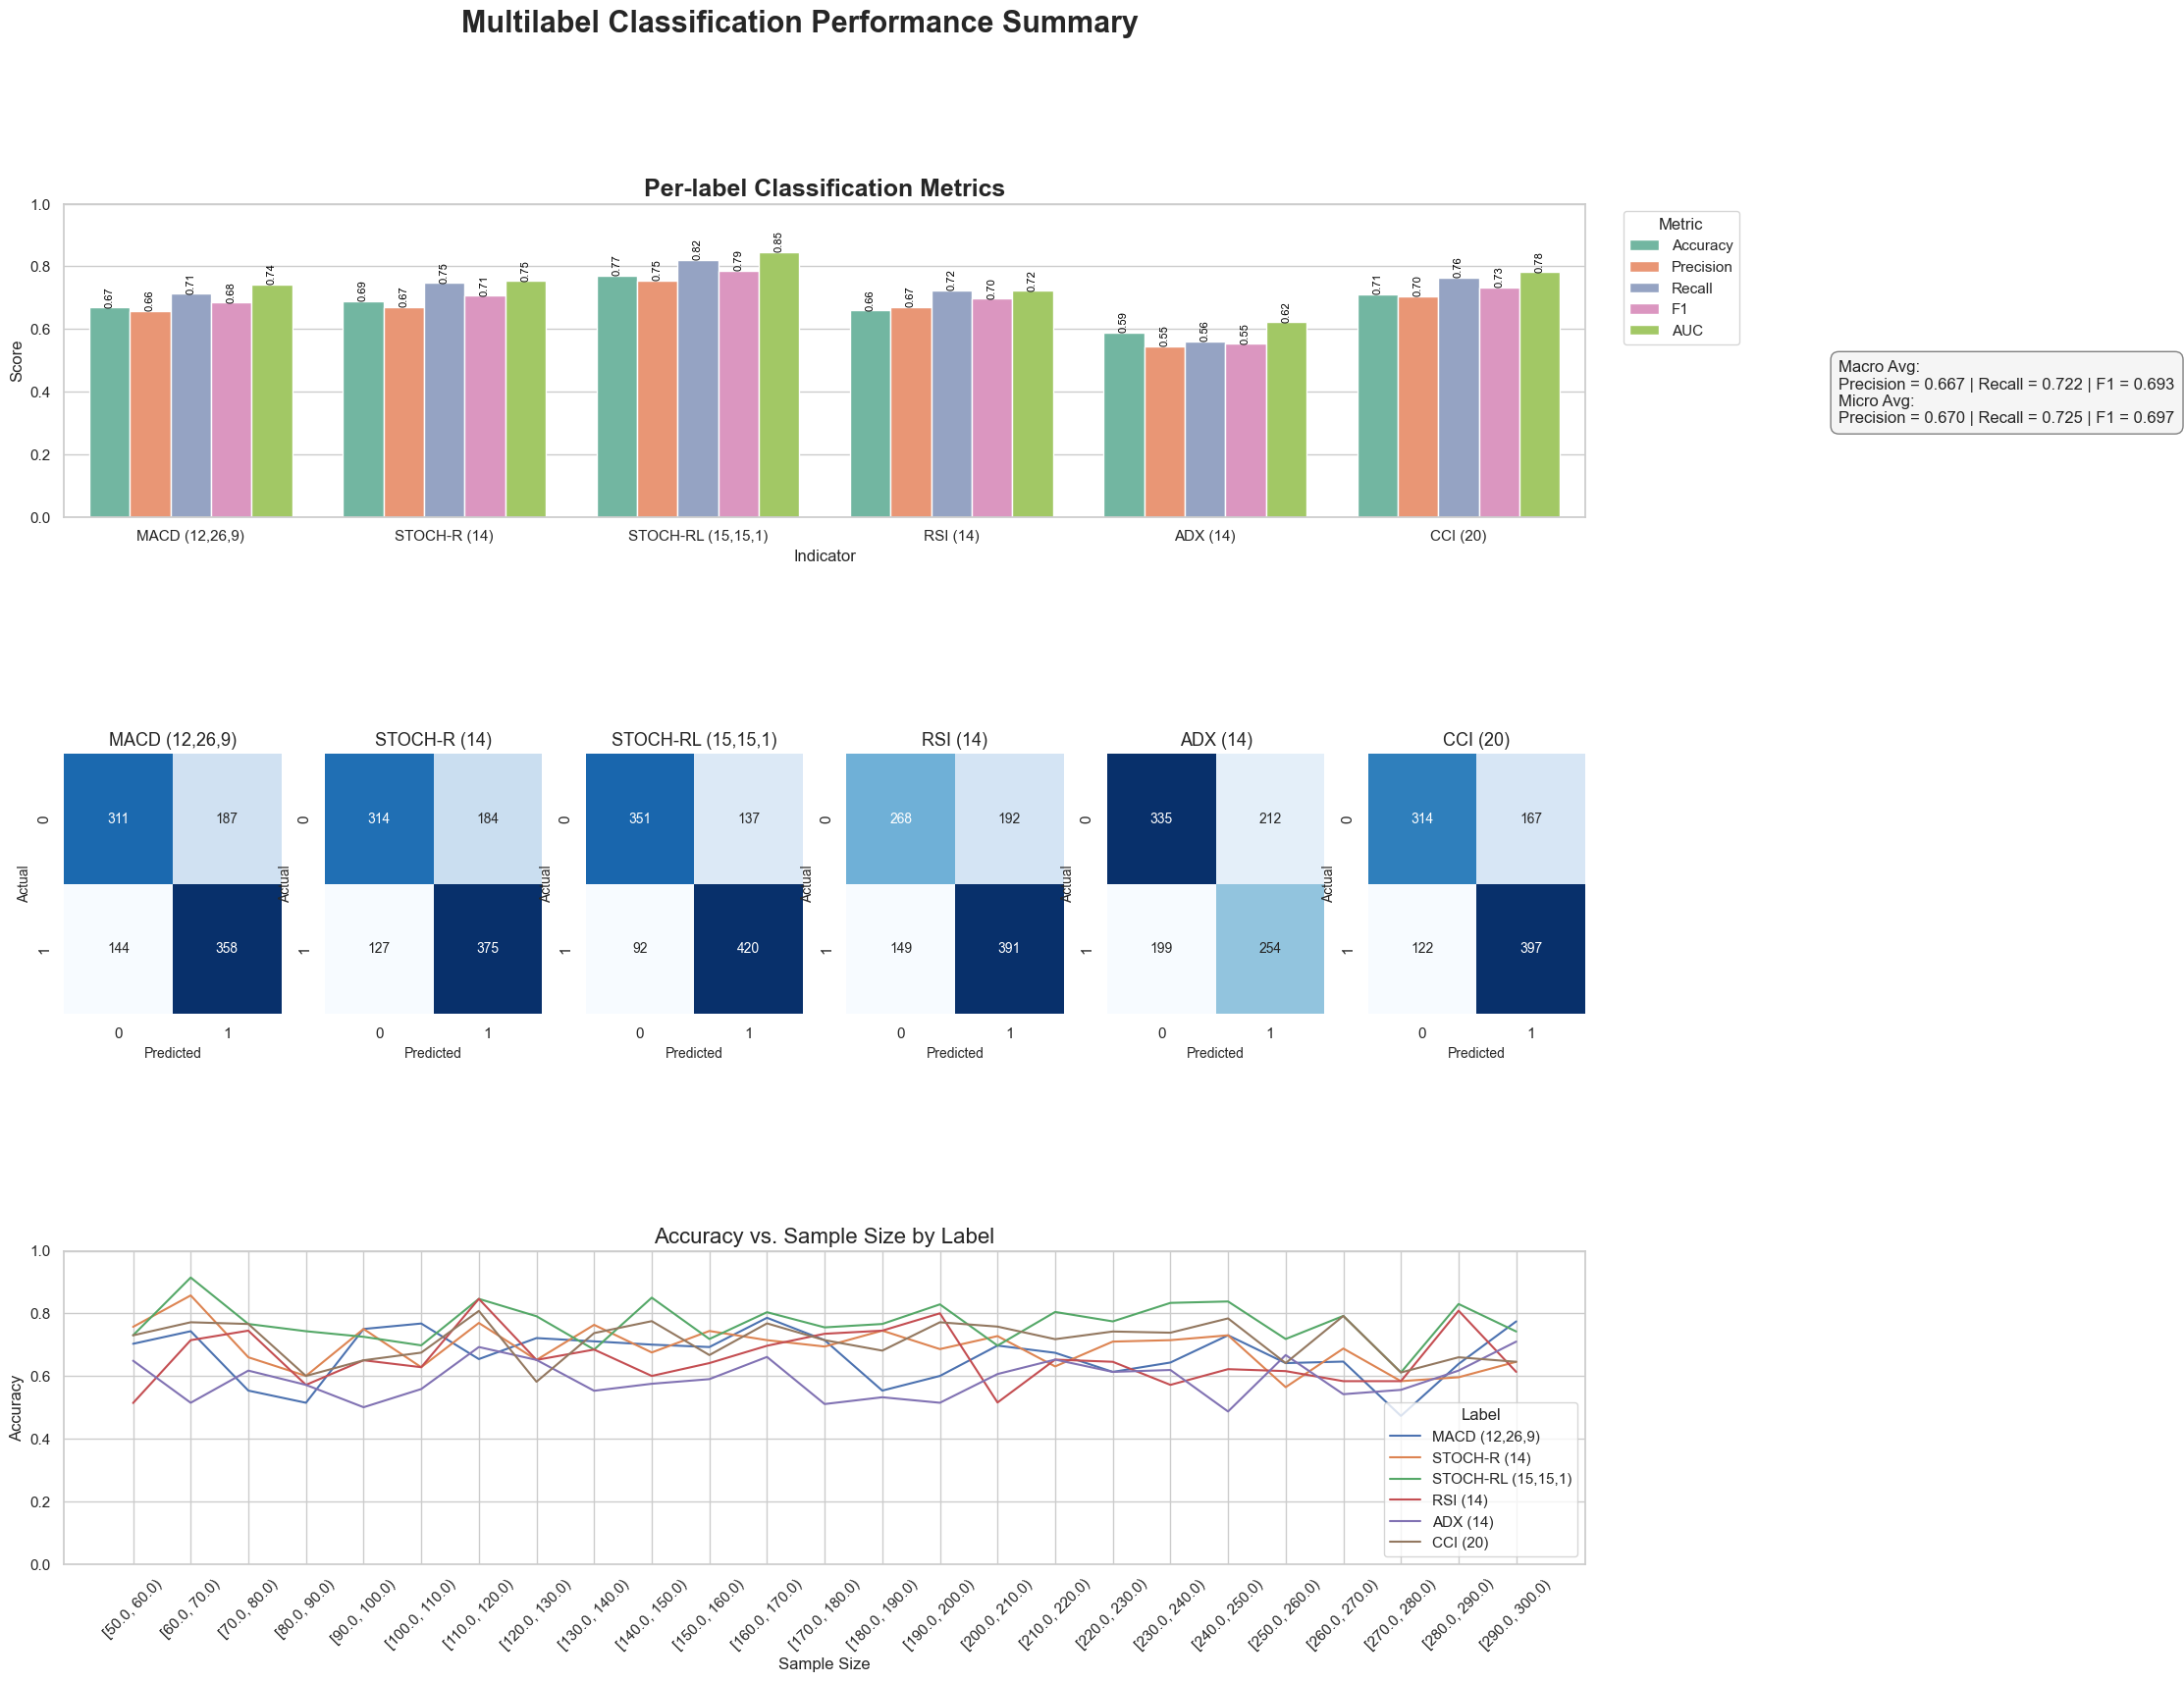

In [ ]:
indics = ['MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)', 'RSI (14)', 'ADX (14)', 'CCI (20)']

all_labels, all_preds, all_probs, _, all_lens, _ = inference (model, small_synth_test_loader, INDICS, DEVICE)



plot_full_evaluation_dashboard(all_labels, all_preds, all_probs, all_lens, indics, save_path = PERF_PATH)

In [ ]:
torch.save(model.state_dict(), MODEL_PATH)

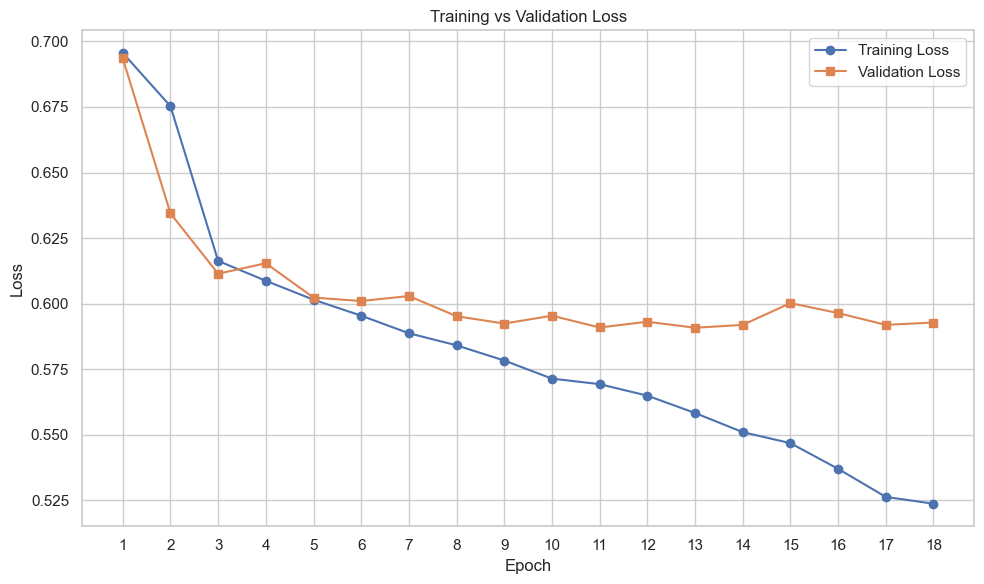

In [ ]:
import matplotlib.pyplot as plt

# Training and validation loss values you provided
train_loss = [
    0.6956, 0.6753, 0.6163, 0.6087, 0.6015, 0.5954,
    0.5887, 0.5841, 0.5783, 0.5714, 0.5693, 0.5649,
    0.5583, 0.5510, 0.5468, 0.5370, 0.5263, 0.5237
]

val_loss = [
    0.6935, 0.6344, 0.6114, 0.6154, 0.6023, 0.6010,
    0.6029, 0.5952, 0.5924, 0.5954, 0.5909, 0.5931,
    0.5908, 0.5919, 0.6002, 0.5964, 0.5919, 0.5928
]

epochs = range(1, len(train_loss) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
for i, (x, y,*_) in enumerate(train_loader):
    print(f"Batch {i+1}: batch size = {x.size(0)}")

Batch 1: batch size = 32
Batch 2: batch size = 32
Batch 3: batch size = 32
Batch 4: batch size = 32
Batch 5: batch size = 32
Batch 6: batch size = 32
Batch 7: batch size = 32
Batch 8: batch size = 32
Batch 9: batch size = 32
Batch 10: batch size = 32
Batch 11: batch size = 32
Batch 12: batch size = 32
Batch 13: batch size = 32
Batch 14: batch size = 32
Batch 15: batch size = 32
Batch 16: batch size = 32
Batch 17: batch size = 32
Batch 18: batch size = 32
Batch 19: batch size = 32
Batch 20: batch size = 32
Batch 21: batch size = 32
Batch 22: batch size = 32
Batch 23: batch size = 32
Batch 24: batch size = 32
Batch 25: batch size = 32
Batch 26: batch size = 32
Batch 27: batch size = 32
Batch 28: batch size = 32
Batch 29: batch size = 32
Batch 30: batch size = 32
Batch 31: batch size = 32
Batch 32: batch size = 32
Batch 33: batch size = 32
Batch 34: batch size = 32
Batch 35: batch size = 32
Batch 36: batch size = 32
Batch 37: batch size = 32
Batch 38: batch size = 32
Batch 39: batch size 

In [ ]:
img = test_dataset[1][0]
img = img.unsqueeze(0)
img = img.to(DEVICE)
model.eval()
model(img)

tensor([[0.5140, 0.5035, 0.5002, 0.4996, 0.4726, 0.5061]],
       grad_fn=<SigmoidBackward0>)